## Plots for Single Echo Results

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
from collections import defaultdict
import pandas
import json
import sys
import glob
import IPython.display as ipd
sys.path.append("..")
sys.path.append("../src")
from prepare_echo_dataset_pn import PN_PATTERNS_1024_8

In [2]:
echoes = [50, 75, 76, 100]
durs = [5, 10, 30, 60]

## Rave Results
# res['Moosmusic - Big Dummy Shake']['5']['drums']['z_50']
results_rave = {i:{dur:{} for dur in durs} for i in ["drums", "vocals", "guitar"]}
for key in results_rave.keys():
    for dur in results_rave[key].keys():
        for echo in echoes:
            results_rave[key][dur][echo] = []
        for f in glob.glob("results/rave_demucs_seed*.json"):
            res = json.load(open(f))
            for tune in res.keys():
                for echo in echoes:
                    results_rave[key][dur][echo] = np.concatenate((results_rave[key][dur][echo], res[tune][f"{dur}"][key][f"z_{echo}"]))


## DDSP Results
results_ddsp = {i:{dur:{} for dur in durs} for i in ["drums", "vocals", "guitar"]}
for key in results_ddsp.keys():
    for dur in results_ddsp[key].keys():
        for echo in echoes:
            results_ddsp[key][dur][echo] = []
        for f in glob.glob("results/ddsp_demucs_seed*.json"):
            res = json.load(open(f))
            for tune in res.keys():
                for echo in echoes:
                    results_ddsp[key][dur][echo] = np.concatenate((results_ddsp[key][dur][echo], res[tune][f"{dur}"][key][f"z_{echo}"]))

results_dd = {i:{dur:{} for dur in durs} for i in ["drums", "vocals", "guitar"]}
for key in results_dd.keys():
    for echo in echoes:
        for dur in durs:
            results_dd[key][dur][echo] = []
    for f in glob.glob("results/diffusion_demucs_seed*.json"):
        res = json.load(open(f))
        for tune in res.keys():
            for dur in results_dd[key].keys():
                for echo in echoes:
                    results_dd[key][dur][echo] = np.concatenate((results_dd[key][dur][echo], res[tune][f"{dur}"][key][f"z_{echo}"]))


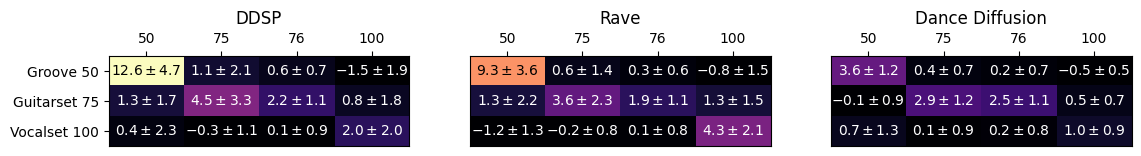

In [3]:
fac = 1.2
plt.figure(figsize=(fac*11, fac*7))
dur = 5
instruments = ["drums", "guitar", "vocals"]
titles = {"drums":"Groove 50", "guitar":"Guitarset 75", "vocals":"Vocalset 100"}
vmin = 0
vmax = 12
for col, (results, model) in enumerate(zip([results_ddsp, results_rave, results_dd], ["DDSP", "Rave", "Dance Diffusion"])):
    plt.subplot(1, 3, col+1)
    D = np.zeros((len(instruments), len(echoes)))
    S = np.zeros((len(instruments), len(echoes)))
    for i, instrument in enumerate(instruments):
        for j, echo in enumerate(echoes):
            zs = results[instrument][dur][echo]
            mu = np.mean(zs)
            std = np.std(zs)
            D[i, j] = mu
            S[i, j] = std
    plt.imshow(D, aspect=0.4, cmap='magma', interpolation='none', vmin=vmin, vmax=vmax)
    plt.xticks(np.arange(len(echoes)), echoes)
    plt.gca().tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    plt.title(model)
    if col == 0:
        plt.yticks(np.arange(len(instruments)), [titles[instrument] for instrument in instruments])
    else:
        plt.yticks([])
    for i in range(D.shape[0]):
        for j in range(D.shape[1]):
            color = 'white'
            if D[i, j] > vmin + 0.6*(vmax-vmin):
                color = 'black'
            plt.text(j, i, "${:.1f} \\pm {:.1f}$".format(D[i, j], S[i, j]), color=color, horizontalalignment='center', verticalalignment='center')
plt.savefig("../Writeup/figs/DemucsZScores.svg", bbox_inches='tight')